# MOwNiT

## Julia Smerdel, ZadanieDomowe5


Zad 1. Uruchomienie metod.

In [47]:
using DataFrames, Plots, Statistics

function naive_multiplication(A,B)
    C = zeros(Float64, size(A,1), size(B,2))
    for i=1:size(A,1)
        for j=1:size(B,2)
            for k=1:size(A,2)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    C
end


function better_multiplication(A, B)
    C = zeros(Float64, size(A,1), size(B,2))
    for j=1:size(B,2)
        for k=1:size(A,2)
            for i=1:size(A,1)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    C
end

function BLAS(A, B)
    return A*B
end


df = DataFrame(Size=Int64[], Type=String[], Time=Float64[])

for i in 1:10:100
    for j in 1:10 #10 times each size
        A = rand(i, i)
        B = rand(i, i)
        push!(df, (i, "Naive", @elapsed naive_multiplication(A, B)))
        push!(df, (i, "Better", @elapsed better_multiplication(A, B)))
        push!(df, (i, "BLAS", @elapsed BLAS(A, B)))
    end
end


stats = combine(groupby(df, [:Type, :Size]), "Time" => mean, "Time" => std)


Row,Type,Size,Time_mean,Time_std
,String,Int64,Float64,Float64
1,Naive,1,1.9e-7,2.96086e-7
2,Better,1,2.9e-7,5.13052e-7
3,BLAS,1,2.02e-6,5.68542e-6
4,Naive,11,1.92e-6,2.20101e-7
5,Better,11,1.56e-6,4.5753e-7
6,BLAS,11,1.04e-6,6.44981e-7
7,Naive,21,1.475e-5,1.9968e-6
8,Better,21,8.83e-6,7.6019e-7
9,BLAS,21,1.96e-6,5.23238e-7


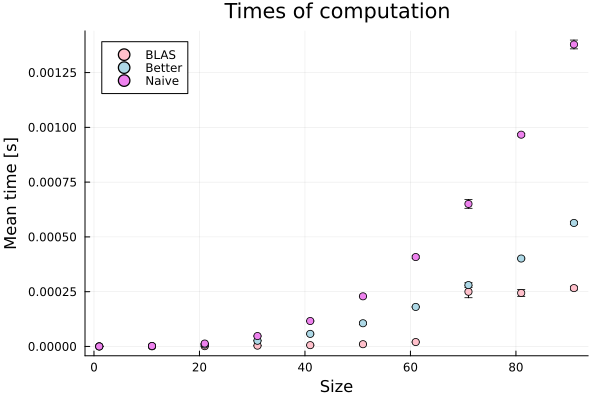

In [11]:
using Plots
scatter(stats.Size, stats.Time_mean, group = stats.Type, yerr = stats.Time_std, xlabel = "Size", ylabel = "Mean time [s]", title="Times of computation", colour=[:pink :lightblue :violet])

Zad 2. Porównanie metod mnożenia macierzy w języku C.

```C
#include <stdio.h>
#include <stdlib.h>
#include <gsl/gsl_blas.h>
#include <gsl/gsl_sf_bessel.h>
#include <sys/times.h>
#include <unistd.h>
#include <fcntl.h>
struct tms timeStart, timeEnd;
clock_t clockStart, clockEnd;

void startTimer(){
    clockStart = times(&timeStart);
}
double endTimer(){
    clockEnd = times(&timeEnd);
    int tiktak = sysconf(_SC_CLK_TCK);
    double real = (double)(clockEnd-clockStart) / tiktak;
    return real;
}
void naive_multiplication(double** A, double** B, double** C, int size){
    for (int i = 0; i < size;i++){
        for (int j = 0; j < size; j++){
            for (int k = 0; k < size; k ++){
                C[i][j] += A[i][k]*B[k][j];
            }
        }     
    }
}
void better_multiplication(double** A, double** B, double** C, int size){
    for (int i = 0; i < size; i++){
        for (int k = 0; k < size; k ++){
            for (int j = 0; j < size; j++){
                C[i][j] += A[i][k]*B[k][j];
            }
        }
    }    
}

void blas_multiplication(double* a, double* b, double* c, int rows){
    gsl_matrix_view D = gsl_matrix_view_array(a, rows, rows);
    gsl_matrix_view E = gsl_matrix_view_array(b, rows, rows);
    gsl_matrix_view F = gsl_matrix_view_array(c, rows, rows);
    gsl_blas_dgemm (CblasNoTrans, CblasNoTrans,
                  1.0, &D.matrix, &E.matrix,
                  0.0, &F.matrix);
}

double** createMatrix(int size){
    double** A = calloc(size, sizeof(double*));
    for(int i = 0; i < size; i++){
        A[i] = calloc(size, sizeof(double));
        for(int j = 0; j < size; j++){
            A[i][j] = rand()%10;
        }
    }

    return A;

}

double** createMatrixZeros(int size){
    double** A = calloc(size, sizeof(double*));
    for(int i = 0; i < size; i++){
        A[i] = calloc(size, sizeof(double));
        for(int j = 0; j < size; j++){
            A[i][j] = 0;
        }
    }

    return A;

}

void freeMatrix(double** A, int size){
    for(int i = 0; i < size; i++){
        free(A[i]);
    }
    free(A);
}

int main(int argc, char** argv){
    
    double timeNaive, timeBetter, timeBLAS;
    FILE* result = fopen("result.csv", "w");
    fprintf(result, "%s,%s,%s", "Size", "Type", "Time");

    for(int i = 1; i < 500; i+=10){
        for (int j = 1; j < 10; j++){
            double** A, **B, **C;
            A = createMatrix(i);
            B = createMatrix(i);
            C = createMatrixZeros(i);


            //naive
            startTimer();
            naive_multiplication(A, B, C, i);
            timeNaive = endTimer();
            freeMatrix(C, i);
            fprintf(result, "\n%d, %s, %f", i, "Naive", timeNaive);

            //better
            C = createMatrixZeros(i);
            startTimer();
            better_multiplication(A, B, C, i);
            timeBetter = endTimer();
            fprintf(result, "\n%d, %s, %f", i, "Better", timeBetter);


            freeMatrix(A,i);
            freeMatrix(B,i);
            freeMatrix(C,i);

            //BLAS
            double *a = calloc(i*i, sizeof(double));
            double *b = calloc(i*i, sizeof(double));
            double *c = calloc(i*i, sizeof(double));
            for (int k = 0; k < i*i; k++){
                a[i] = rand()%10;
                b[i] = rand()%10;
                c[i] = 0.0;
            }

            startTimer();
            blas_multiplication(a, b, c, i);
            timeBLAS = endTimer();
            fprintf(result, "\n%d, %s, %f", i, "BLAS", timeBLAS);
            free(a);
            free(b);
            free(c);

            
        }
    }
    fclose(result);
    return 0;
}
```

In [19]:
using CSV, DataFrames
data = CSV.read("result.csv", DataFrame)
stats = combine(groupby(data, [:Type, :Size]), "Time" => mean, "Time" => std)

Row,Type,Size,Time_mean,Time_std
,String7,Int64,Float64,Float64
1,Naive,1,0.0,0.0
2,Naive,11,0.0,0.0
3,Naive,21,0.0,0.0
4,Naive,31,0.0,0.0
5,Naive,41,0.0,0.0
6,Naive,51,0.00111111,0.00333333
7,Naive,61,0.00111111,0.00333333
8,Naive,71,0.00111111,0.00333333
9,Naive,81,0.00222222,0.00440959


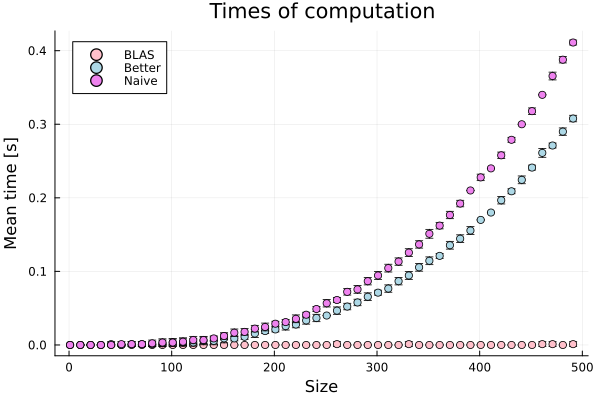

In [20]:
using Plots
scatter(stats.Size, stats.Time_mean, group = stats.Type, yerr = stats.Time_std, xlabel = "Size", ylabel = "Mean time [s]", title="Times of computation", colour=[:pink :lightblue :violet])

Zad 3. Aproksymacja wielomianami.

In [55]:
xVals = stats[stats[:,1] .== "Naive", 2]
onlyNaive = stats[stats[:,1] .== "Naive", 3]
onlyBetter = stats[stats[:,1] .== "Better", 3]
onlyBLAS = stats[stats[:,1] .== "BLAS", 3]


10-element Vector{Int64}:
  1
 11
 21
 31
 41
 51
 61
 71
 81
 91

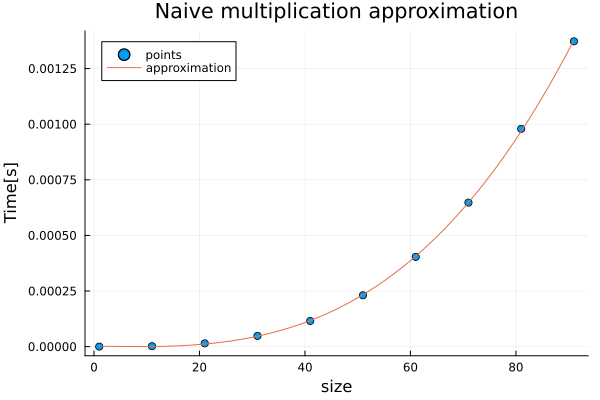

In [63]:
using Polynomials
fitNaive = fit(xVals, onlyNaive, 3)
scatter(xVals, onlyNaive, label="points", xlabel="size", ylabel="Time[s]")
plot!(fitNaive, extrema(xVals)..., title="Naive multiplication approximation", label="approximation")

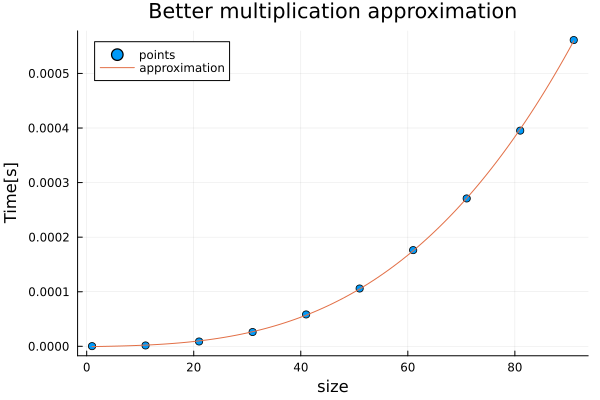

In [69]:
using Polynomials
fitBetter = fit(xVals, onlyBetter, 3)
scatter(xVals, onlyBetter, label="points", xlabel="size", ylabel="Time[s]")
plot!(fitBetter, extrema(xVals)..., title="Better multiplication approximation", label="approximation")

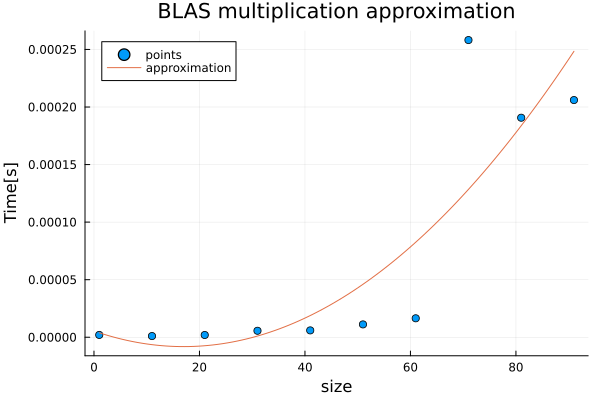

In [71]:
using Polynomials
fitBLAS = fit(xVals, onlyBLAS, 2)
scatter(xVals, onlyBLAS, label="points", xlabel="size", ylabel="Time[s]")
plot!(fitBLAS, extrema(xVals)..., title="BLAS multiplication approximation", label="approximation")

Dla metod naive_multiplication oraz better_multiplication dobrany został wielomian 3. stopnia (3 pętle for). Operacja BLAS dla $O(n^2)$ danych wykonuje $O(n^3)$ ("Level 1 BLAS operations typically take linear time, O(n), Level 2 operations quadratic time and Level 3 operations cubic time. Modern BLAS implementations typically provide all three levels." ~ Wikipedia)

Zad 4. Zniwelowanie efektu Rungego.

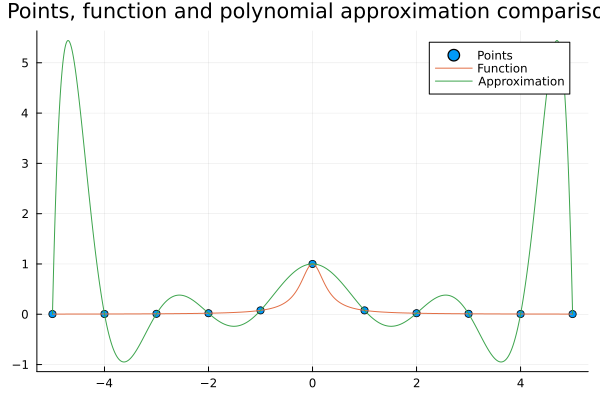

In [93]:
function toApprox(x)
    1/(1+12x^2)
end

xVals = -5:1:5
yVals = [toApprox(x) for x in xVals]
polynomialApprox = fit(xVals, yVals, 10)
xApprox = -5:0.01:5
yApprox = [polynomialApprox(x) for x in xApprox]

scatter(xVals, yVals, label="Points", title="Points, function and polynomial approximation comparison")
plot!(toApprox, extrema(xVals)..., label="Function")
plot!(xApprox, yApprox, label="Approximation")

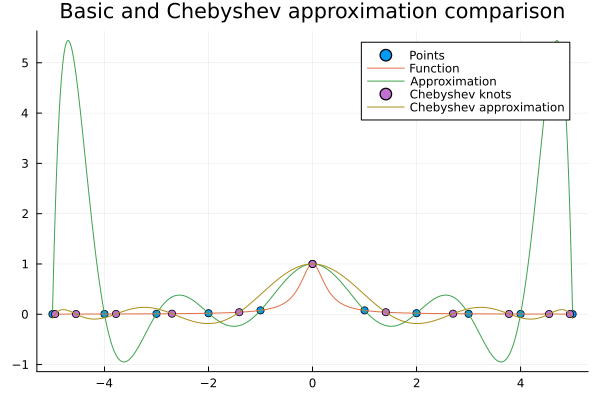

In [94]:
using Polynomials
base = [0,0,0,0,0,0,0,0,0,0,0,1]
czebyszew = ChebyshevT(base)
knots = Polynomials.roots(czebyszew)
knots = 5*knots

ys = [toApprox(x) for x in knots]
polynomialApprox2 = fit(knots, ys, 10)
scatter!(knots, ys, label="Chebyshev knots", title="Basic and Chebyshev approximation comparison")

ys2 = [polynomialApprox2(x) for x in xApprox]
plot!(xApprox, ys2, label="Chebyshev approximation")



Zad 5. Przybliżenie Pade

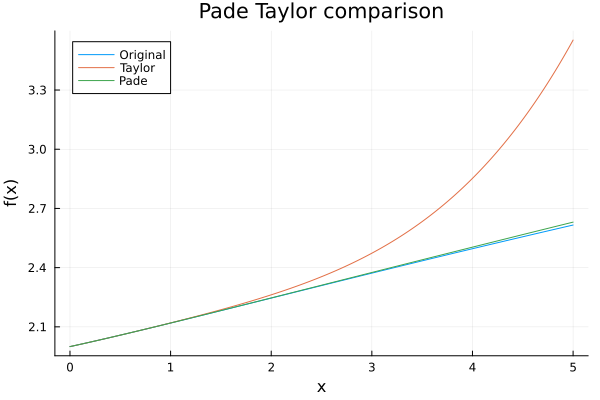

In [104]:
using TaylorSeries

function fun(x)
    (7+(1+x)^(4/3))^(1/3)
end


Taylor = Taylor1(Float64, 4)
TaylorTest = fun(Taylor)
TaylorApprox = Polynomial(TaylorTest.coeffs)

PadeApprox = Polynomials.PolyCompat.PadeApproximation.Pade(TaylorApprox, 2, 2)

xVals = 0:0.01:5
y1 = [fun(x) for x in xVals]
y2 = [TaylorApprox(x) for x in xVals]
y3 = [PadeApprox(x) for x in xVals]

plot(xVals, [y1, y2, y3], xlabel="x", ylabel="f(x)", title="Pade Taylor comparison", label=["Original" "Taylor" "Pade"])

